In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

plt.figure(figsize=(10, 10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

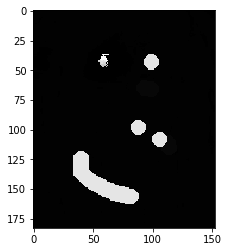

In [2]:
data_path = 'depth_roi_data/fake_depth_roi_many.png'
chip = cv2.imread(data_path, cv2.IMREAD_ANYDEPTH)

plt.imshow(chip, cmap='gray')

In [3]:
accepted_depth = 550
epsilon = 1000

rows = chip.shape[0]
cols = chip.shape[1]

Number of invalid pixels: 1893


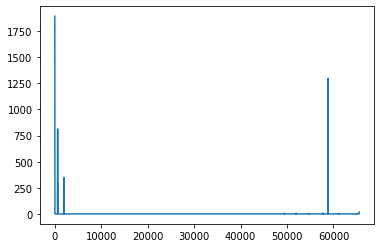

In [4]:
# Find number of zero pixels
hist = np.zeros(shape=(65536)).astype(np.uint32)
for row in range(0, rows):
    for col in range(0, cols):
        hist[chip[row, col]] += 1

plt.plot(hist)

print('Number of invalid pixels: {}'.format(hist[0]))

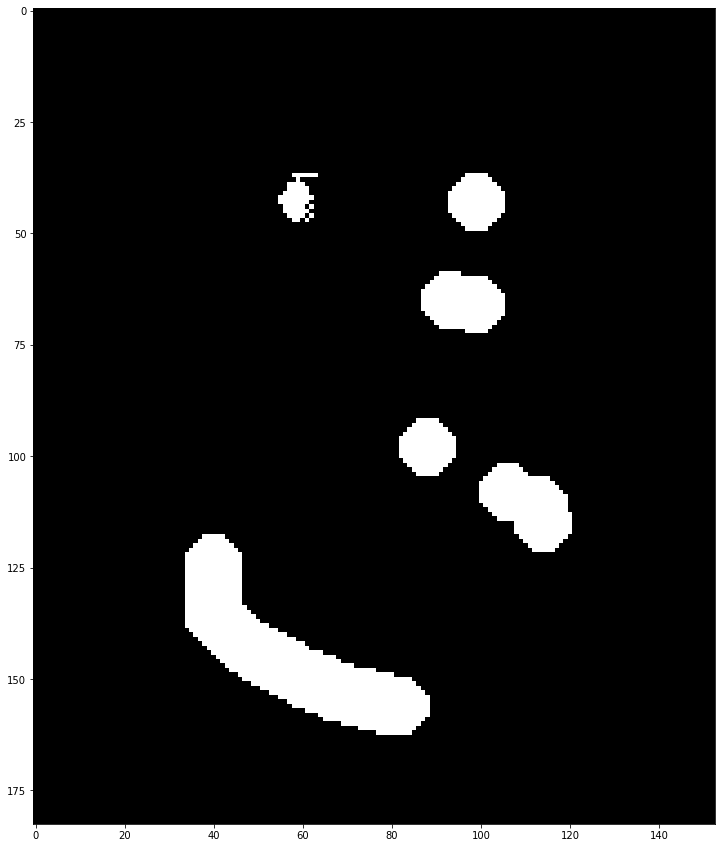

In [5]:
# Identify outliers
mask = np.zeros(shape=(rows, cols))

for row in range(0, rows):
    for col in range(0, cols):
        if np.fabs(accepted_depth - chip[row, col]) < epsilon:
            mask[row, col] = 1
            
mask = np.logical_not(mask)

plt.figure(figsize=(15, 15))
plt.imshow(mask, cmap='gray')
plt.savefig('binary_mask_fake_blobs.png')

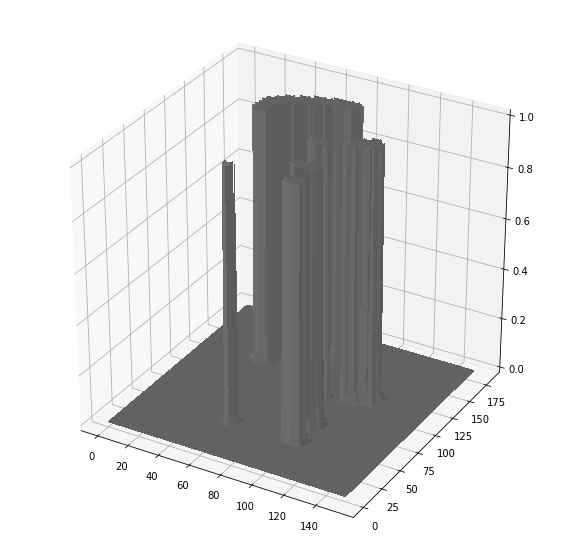

In [6]:
# Locate blobs
# A blob is a collection of pixel coordinates
class point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    @staticmethod
    def find_in(pnts, blobs):
        if len(blobs) == 0:
            return -1
        for i in range(0, len(blobs)):
            blob = blobs[i]
            num_found_pnts = 0
            for pnt in pnts:
                for ii in range(0, len(blob)):
                    blob_pnt = blob[ii]
                    if blob_pnt.x == pnt.x and blob_pnt.y == pnt.y:
                        return i
        return -1

# 3Dplot
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
xx, yy = np.meshgrid(range(0, mask.shape[1]), range(0, mask.shape[0]))
surf = ax.plot_surface(xx, yy, mask, color='gray', linewidth=0, antialiased=False)
plt.savefig('binary_3d_fake_blobs.png')

[[2, 2, 2], [], [], [], [], [], []]
Conflict idx:  2
Conflict idx:  2
Conflict idx:  2
Number of blobs:  4


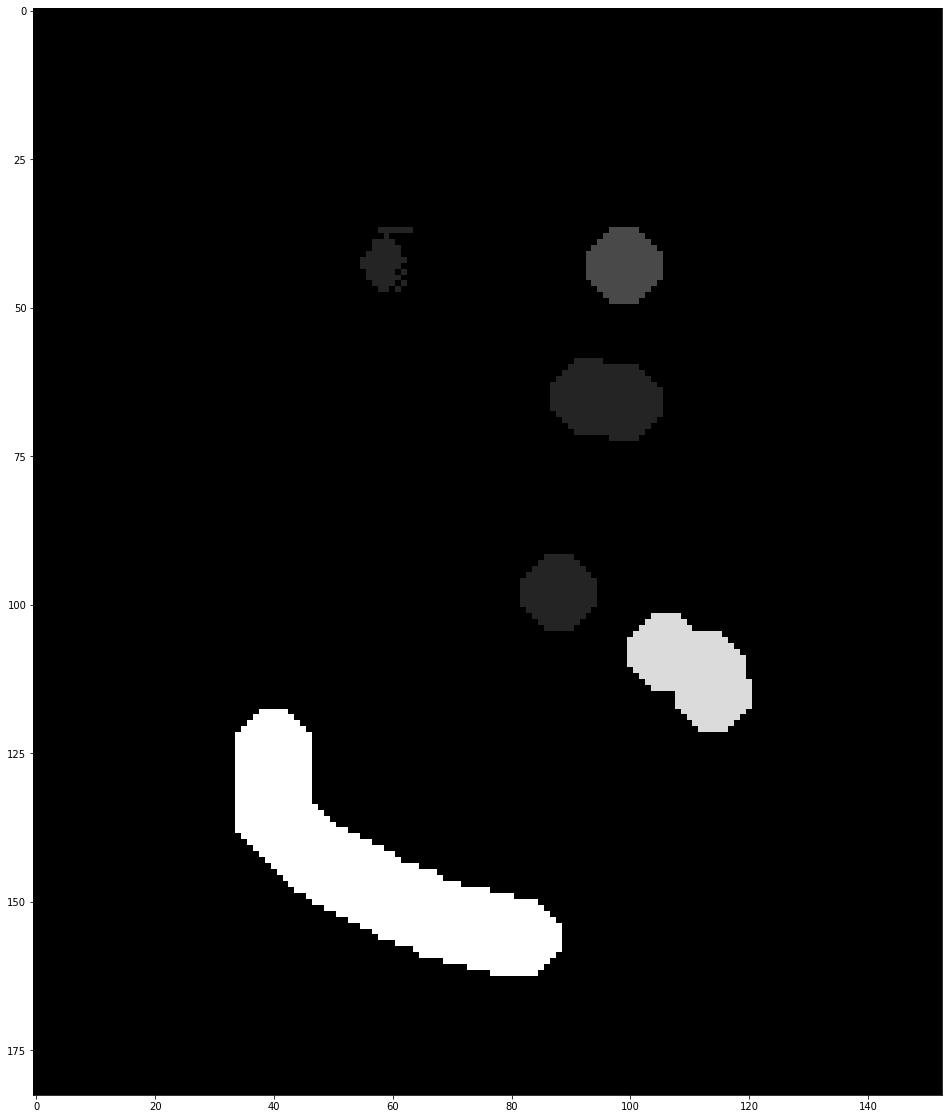

In [7]:
import copy

# Connected labels algorithm
labels_mask = copy.deepcopy(mask).astype(np.uint8)

#(1) First pass: identify labels
blobs = []; equivalent = []
for row in range(1, rows):
    for col in range(1, cols):
        pxl = mask[row, col]
        # Is it a valid pixel inetnsity?
        if pxl == 1:
            # Check previous pixels
            up = point(col, row - 1)
            left = point(col - 1, row)
            left_diag = point(col - 1, row - 1)
            right_diag = point(col + 1, row - 1)
            
            up_val = labels_mask[up.y, up.x]
            left_val = labels_mask[left.y, left.x]
            left_diag_val = labels_mask[left_diag.y, left_diag.x]
            right_diag_val = labels_mask[right_diag.y, right_diag.x]
            
            new_pnt = point(col, row)
                
            if len(blobs) > 0 and (up_val > 0 or left_val > 0 or left_diag_val > 0 or right_diag_val > 0):
                
                #(A) take the smallest that is not equal to 0
                values = [up_val, left_val, left_diag_val, right_diag_val]
                nonzeros = [val for val in values if val != 0]
                min_val = np.min(nonzeros)
                blobs[min_val - 1].append(new_pnt)
                labels_mask[row, col] = min_val
                
                #(B) take care of conflicts
                for val in nonzeros:
                    candidate_idx = val - 1
                    if val > min_val and candidate_idx not in equivalent[min_val - 1]:
                        equivalent[min_val - 1].append(candidate_idx)
            else:
                equivalent.append([])
                # Mark the labels from 1 .. N
                blobs.append([new_pnt])
                labels_mask[row, col] = len(blobs)
                
#(2) Second pass: merge labels
print(equivalent)
assert(len(equivalent) == len(blobs))

for i in range(0, len(blobs)):
    if len(equivalent[i]) > 0:
        for idx_val in equivalent[i]:
            print('Conflict idx: ', idx_val)
            for pnt in blobs[idx_val]:
                labels_mask[pnt.y, pnt.x] = i + 1
                blobs[i].append(pnt)
            del blobs[idx_val]
                
print('Number of blobs: ', len(blobs))
plt.figure(figsize=(20, 20))
plt.imshow(labels_mask, cmap='gray')
plt.savefig('fake_blobs.png')

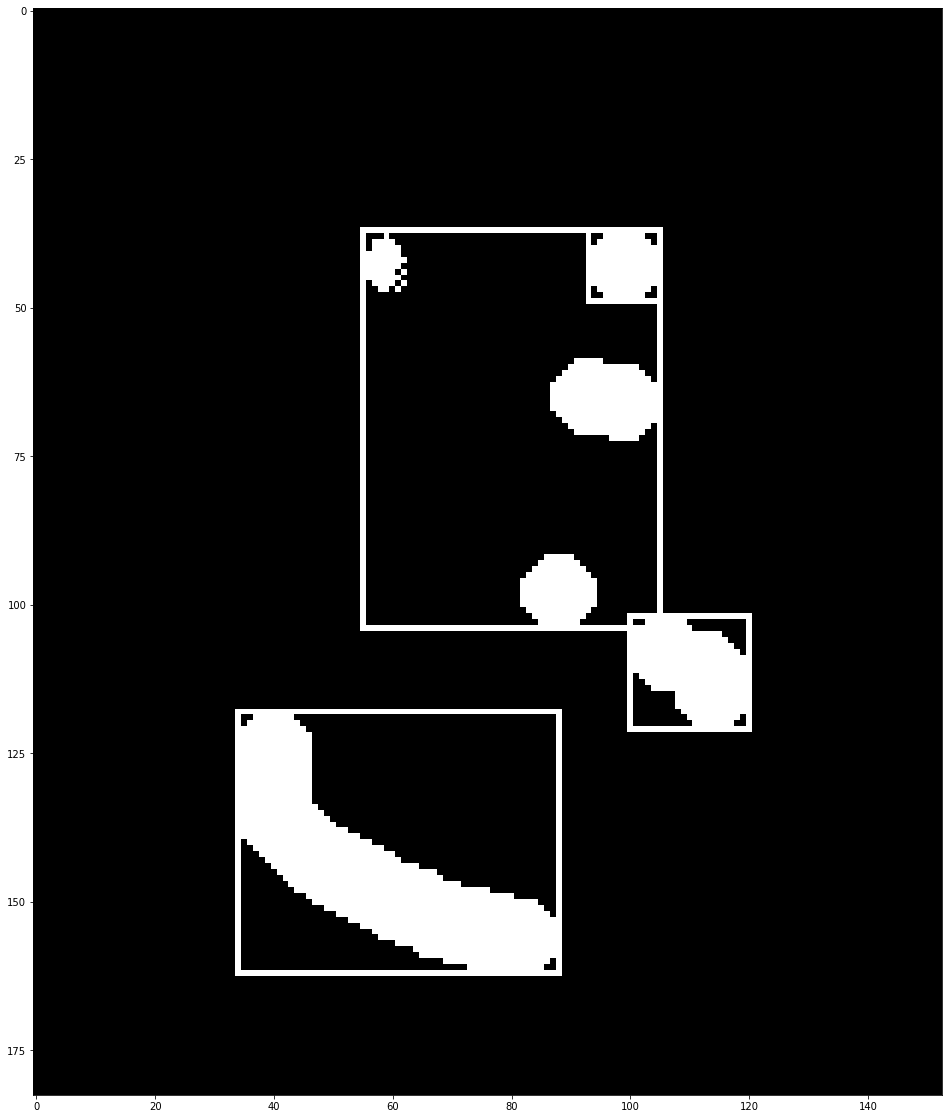

In [8]:
#Draw rectangles around them
orig_mask = copy.deepcopy(mask).astype(np.uint8)
disp = copy.deepcopy(mask).astype(np.uint8)
for blob in blobs:
    tl_x = int(np.min([pnt.x for pnt in blob]))
    tl_y = int(np.min([pnt.y for pnt in blob]))
    br_x = int(np.max([pnt.x for pnt in blob]))
    br_y = int(np.max([pnt.y for pnt in blob]))
    disp = cv2.rectangle(disp, (tl_x, tl_y), (br_x, br_y), (1, 1, 1), thickness=1)
    
disp = cv2.bitwise_or(disp, orig_mask)
    
plt.figure(figsize=(20, 20))    
plt.imshow(disp, cmap='gray')
plt.savefig('found_fake_blobs.png')

In [ ]:
# Flood fill algorithm:
def is_in(pnt, blobs):
    return True

blobs = []
for row in range(0, rows):
    for col in range(0, cols):
        pxl = mask[row, col]
        is_connection_lost = False
        pnt = point(col, row)
        if is_in(pnt, blobs):
            blobs.append([pnt])
            
            connected = []
            up = point(col, row - 1) if row > 0 else point(col, row)
            down = point(col, row + 1) if row < rows - 1 else point(col, rows - 1)
            left = point(col - 1, row) if col > 0 else point(col, row)
            right = point(col + 1, row) if col < cols - 1 else point(cols - 1, row)
                
            if mask[up.y, up.x]:
                connected.append(up)
            if mask[down.y, down.x]:
                connected.append(down)
            if mask[left.y, left.x]:
                connected.append(left)
            if mask[right.y, right.x]:
                connected.append(right)
                
            for pnt in connected:
                is_connected = True
                while is_connected:
                    pass